[Set up Conda Environment](https://docs.descarteslabs.com/installation.html) and [Authenticate](https://docs.descarteslabs.com/authentication.html) with Descartes Labs CLI before running this notebook

In [1]:
import descarteslabs as dl
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline  

Create a GeoJSON geometry by defining area of interest also called an 'aoi'

In [2]:
sangre_de_cristo_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [-106, 35.5], [-105, 35.5], [-105, 36.5], [-106, 36.5], [-106, 35.5]
    ]]
}

# [Scenes Submodule](https://docs.descarteslabs.com/descarteslabs/scenes/readme.html)

`descarteslabs.scenes`: Object-oriented interface to search for and load imagery. This is the recommended interface for new users.

## Scenes: Searching with `search`

[descarteslabs.scenes.search](https://docs.descarteslabs.com/descarteslabs/scenes/docs/search.html): search for scenes

In [3]:
scenes, geoctx = dl.scenes.search(
    sangre_de_cristo_geojson,
    products=["sentinel-2:L1C", "landsat:LC08:01:T1:TOAR"],
    start_datetime="2016-12-01",
    end_datetime="2018-03-01",
    cloud_fraction=0.1,
)

## [GeoContext](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html)
Often, you don’t have to create GeoContexts yourself—an AOI with default parameters is created for you by scenes.search and Scene.from_id.

In [4]:
print(geoctx)

AOI(geometry=<shapely.geom...x7fa1ce64f128>,
    resolution=10,
    crs='EPSG:32613',
    align_pixels=True,
    bounds=(-106.0, 35.5, -105.0, 36.5),
    shape=None)


`filter`: Returns Collection of items in self for which predicate(item) is True

In [5]:
winter_scenes = scenes.filter(
    lambda scene: scene.properties.date.month in [12, 1, 2]
)

In [6]:
winter_scenes

SceneCollection of 30 scenes
  * Dates: Dec 03, 2016 to Feb 12, 2018
  * Products: landsat:LC08:01:T1:TOAR: 17, sentinel-2:L1C: 13

Print properties of the 8th scene in the collection:

In [7]:
print(winter_scenes[7].properties)

{
  'acquired': '2018-01-27T17:38:25.428684Z',
  'area': 35366.9,
  'bands': {
    'alpha': {
      'color': 'Alpha',
      'data_description': '0: nodata, 1: valid data',
      'data_range': [0, 1],
      'data_unit_description': 'unitless',
      'default_range': [0, 1],
      'description': 'Alpha (valid data)',
      'dtype': 'UInt16',
      'id': 'landsat:LC08:01:T1:TOAR:alpha',
      'jpx_layer': 1,
      'name': 'alpha',
      'name_common': 'alpha',
      'nbits': 1,
      'nodata': None,
      'owner_type': 'core',
      'product': 'landsat:LC08:01:T1:TOAR',
      'res_factor': 1,
      'resolution': 15,
      'resolution_unit': 'm',
      'srcband': 1,
      'srcfile': 0,
      'tags': ['mask', 'alpha', '15m', 'landsat'],
      'type': 'mask'
    },
    'blue': {
      'color': 'Blue',
      'data_description': 'TOAR, 0-10000 is 0 - 100% reflective',
      'data_range': [0, 10000],
      'data_unit': 'TOAR',
      'data_unit_description': 'Top of atmosphere reflectance',
    

`stack`: returns multiple images as a 4-D NumPy array. This is particularly useful for creating time-stacks.

In [8]:
ndarray_stack = winter_scenes.stack(
    "red green blue",
    geoctx.assign(resolution=150)
)

In [9]:
ndarray_stack.shape

(30, 3, 737, 606)

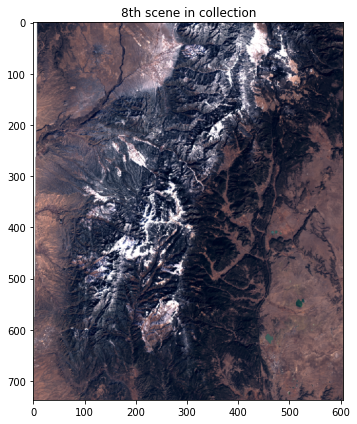

In [10]:
dl.scenes.display(ndarray_stack[7], title="8th scene in collection", size=6)

Create median composite of the 30 scenes:

In [11]:
winter_composite = np.ma.median(ndarray_stack, axis=0)

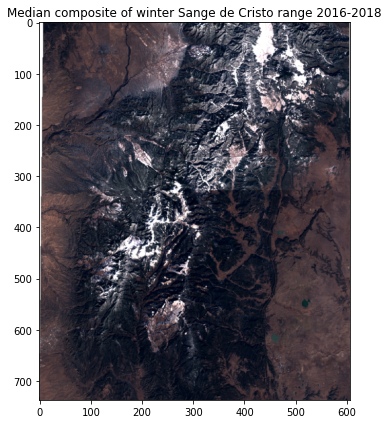

In [12]:
dl.scenes.display(winter_composite, title="Median composite of winter Sange de Cristo range 2016-2018", size=6)


# [Vector Service](https://docs.descarteslabs.com/descarteslabs/vectors/readme.html)
 
TODO

# [Metadata API](https://docs.descarteslabs.com/guides/metadata.html)
Find out what data exists that matches your criteria. Lower-level client that will be deprecated as functionality is added to the object-oriented interface.

## Metadata API - Searching with `search`

`Search`: query parameters include products, place, geometry, DLTile, Start and End Time, Cloud Fraction


In [13]:
places_client = dl.Places()
metadata_client = dl.Metadata()
new_mexico = places_client.find('north-america_united-states_new-mexico')
new_mexico_shape = new_mexico[0]['slug']
features = metadata_client.search("landsat:LC08:PRE:TOAR",start_datetime='2016-03-01',end_datetime='2016-06-30', cloud_fraction=.15, place=new_mexico_shape)
ids = [f['id'] for f in features['features']]
print("There are {} images over New Mexico that are 15% or less cloudy from March to June in 2016".format(len(ids)))

There are 93 images over New Mexico that are 15% or less cloudy from March to June in 2016


## Metadata API - Searching with `features`
`features`: most efficient method for accessing image IDs and their metadata. All parameters are optional. This method is built to handle requests resulting in 10000 returns or more, though it works well for smaller subsets, too.

### example
determine the number of Landsat 8 TOAR images captured over the US from Jan-Jun in 2016

In [14]:
# currently failing with error, sent question to support
places_client = dl.Places()
metadata_client = dl.Metadata()
# new_mexico = places_client.find('north-america_united-states_new-mexico')
# new_mexico_shape = new_mexico[0]['slug']
us = places_client.find('north-america_united-states')
us_shape = us[0]['slug']
features = metadata_client.features("landsat:LC08:PRE:TOAR",start_datetime='2016-01-01',end_datetime='2016-06-30', place=us_shape)
total = 0
for f in features:
   total += 1
print("There were {} Landsat 8 TOAR images captured over the US from January to June in 2016.".format(total))

BadRequestError: {"error":400,"message":"invalid_shape_exception: Self-intersection at or near point (-179.220552467973, 50.961908117601794, NaN)"}


# [Raster API](https://docs.descarteslabs.com/guides/raster.html)
Load data as ndarrays or image files, while handling clipping, reprojection, resampling, and mosaicing of overlapping scenes.

## Raster API - Retrieval with `ndarray`
`ndarray`: returns data as an ndarray

### example:

Retrieve a visible-light image from the Sentinel-2 constellation as a NumPy array.

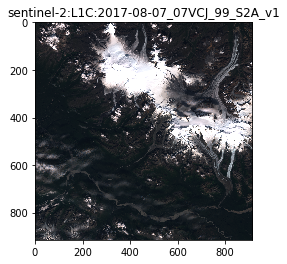

In [15]:
raster_client = dl.Raster()
s2_scene_id = "sentinel-2:L1C:2017-08-07_07VCJ_99_S2A_v1"

s2_arr, s2_meta = raster_client.ndarray(s2_scene_id,
    resolution=120,
    bands=["red", "green", "blue", "alpha"],
    scales=[[0,8000], [0,8000], [0,8000], [0,1]],
    data_type="Byte")
plt.imshow(s2_arr);
plt.title(s2_scene_id);
plt.show();

## Raster API - Retrieval with `raster`
`raster`: returns data as an image file, optionally saving it to disk.
    
It returns a dictionary of information about the raster with a files key, which contains another dictionary mapping a filename to the image file data as a byte array. Passing save=True will save that image file to disk in the current working directory.

### example:
save a GeoTIFF to disk

In [16]:
raster = raster_client.raster("landsat:LC08:PRE:TOAR:meta_LC80330352017056_v1",
    resolution=150,
    bands=["red", "green", "blue", "alpha"],
    save=True)  # save file to disk

print(raster["files"].keys())

os.listdir(os.getcwd())  # image saved as GeoTIFF in current directory


dict_keys(['landsat:LC08:PRE:TOAR:meta_LC80330352017056_v1_red-green-blue-alpha.tif'])


['Descartes Labs Test.ipynb',
 '.ipynb_checkpoints',
 'landsat:LC08:PRE:TOAR:meta_LC80330352017056_v1_red-green-blue-alpha.tif']

## Raster API  - Retrieval with `stack`
`stack`: returns multiple images as a 4-D NumPy array. This is particularly useful for creating time-stacks.

### example:
return two images from LandSat

(2, 1024, 1024, 4)


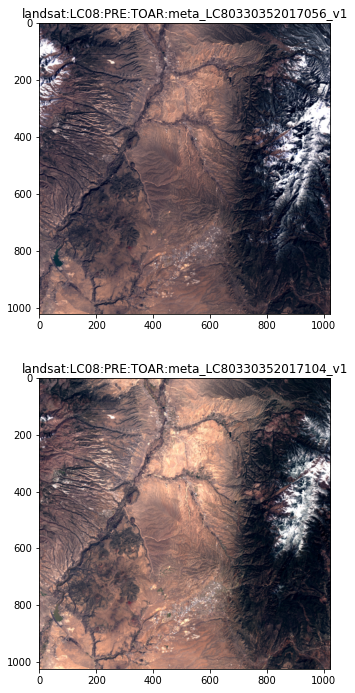

In [17]:
# Two Landsat-8 scenes over Santa Fe, NM in Feb and Apr 2017
scene_ids = [
    "landsat:LC08:PRE:TOAR:meta_LC80330352017056_v1",
    "landsat:LC08:PRE:TOAR:meta_LC80330352017104_v1"
] 

# use a DLTile (see bottom of this guide) to specify explicit resolution, bounds, & SRS.
# required by stack so that each ndarray "layer" has the same shape.
dltile_key = "1024:0:60.0:13:-2:64"

stack, raster_info = raster_client.stack(scene_ids,
    dltile=dltile_key,
    bands=["red", "green", "blue", "alpha"],
    scales=[[0,4000], [0,4000], [0,4000], [0,1]],
    data_type="Byte")

print(stack.shape)

dl.scenes.display(*stack, title=scene_ids, size=5, bands_axis=-1)  # easily show multiple images


[Tasks](https://docs.descarteslabs.com/guides/tasks.html): Run any Python function in parallel in the cloud: similar to AWS Batch or Google Cloud Functions, but with unlimited execution time and zero setup.
* [Storage](https://docs.descarteslabs.com/guides/storage.html): Key-value blob storage atop Google Cloud Storage, authenticated through your Descartes Labs account—helpful for persisting data from Tasks.

In [ ]:
# TODO